In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import scipy.io as sio
import scipy.stats as stats
import cv2

# 1. Convertimos los datos usando $\Delta_{ID}=1$

In [2]:
dir_path = 'masks/'
# add this path to the system path
sys.path.append(dir_path)

In [3]:
files = os.listdir(dir_path)

In [4]:
# create a dictionary of the masks
masks = {}

for file in files:
    name = file.split('_')[0]
    array = sio.loadmat(dir_path + file)['masks']
    n_steps = array.shape[-1]
    grid = np.zeros_like(array)
    grid[:, :, 0] = array[:, :, 0].copy()
    for i in range(1, n_steps):
        grid[:,:,i][grid[:,:,i-1]>=1] = 2
        grid[:,:,i][grid[:,:,i-1]==0] = array[:,:,i][grid[:,:,i-1]==0].copy()    
    masks[name] = grid.copy()


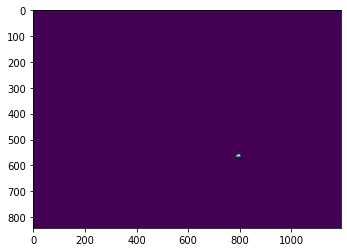

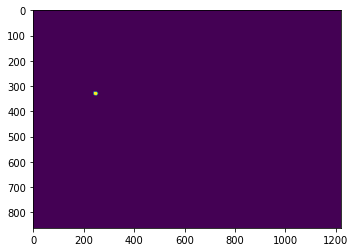

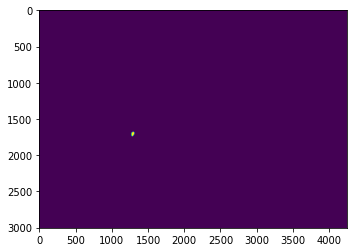

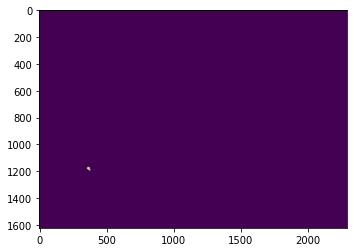

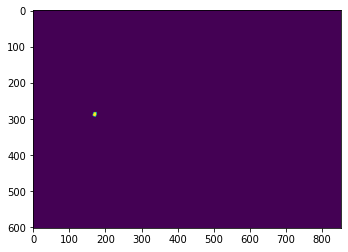

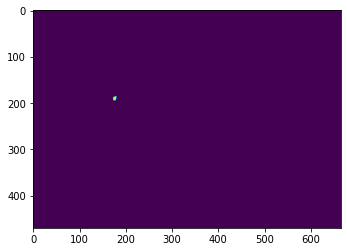

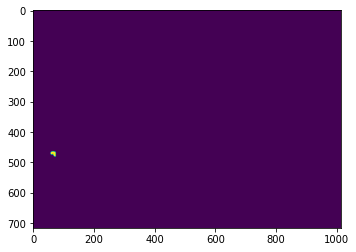

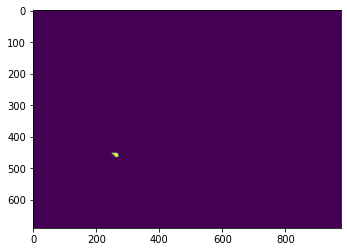

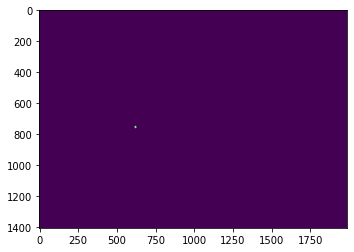

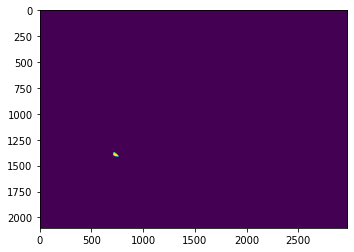

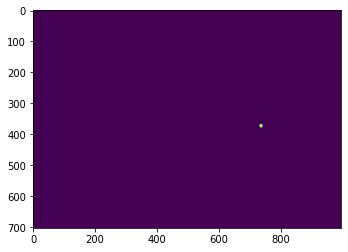

In [5]:
for name in masks.keys():
    
    plt.imshow(masks[name][:,:,0])
    plt.show()

# 2. Guardamos los datos en formato binario

In [6]:
import pickle
with open('grid_data_dict/masks.pkl', 'wb') as f:
    pickle.dump(masks, f)

In [7]:
masks = pickle.load(open('grid_data_dict/masks.pkl', 'rb'))

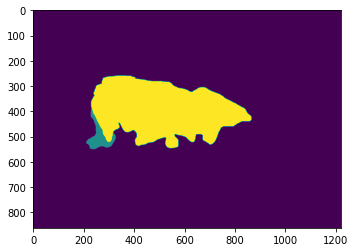

In [8]:
plt.imshow(masks['Beneixama'][:, :, -1])

# 3. Hacemos el CROP 

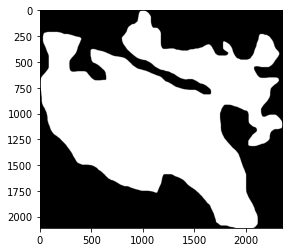

In [9]:
binary_mask = masks['Beniarda'][:, :, -1]
rows, cols = np.nonzero(binary_mask)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)
size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
size = np.max([size_1, size_2])
bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
cropped_mask = binary_mask[min_row:max_row+1, min_col:max_col+1]
plt.imshow(cropped_mask, cmap='gray')
#plt.savefig('cropped_mask_Beniarda.png')
plt.show()

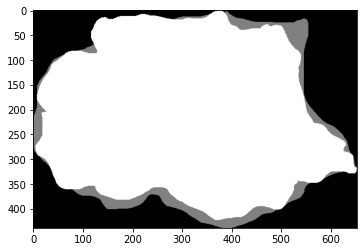

In [10]:
binary_mask = masks['Artana'][:, :, -1]
rows, cols = np.nonzero(binary_mask)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)
size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
size = np.max([size_1, size_2])
bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
cropped_mask = binary_mask[min_row:max_row+1, min_col:max_col+1]
plt.imshow(cropped_mask, cmap='gray')
#plt.savefig('cropped_mask_Artana.png')
plt.show()

max size: 2348
sizes: [653, 655, 2348, 1440, 464, 246, 733, 642, 892, 1820, 593]
max size index: 2
name of max size: Beniarda


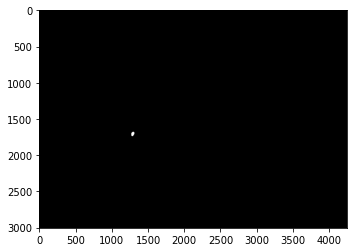

centroid: 1706 1293


In [11]:
def get_bounding_square(mask):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    size = np.max([size_1, size_2])
    return size

sizes = [get_bounding_square(masks[name][:,:,-1]) for name in masks.keys()]
size = np.max(sizes)
if size%2 == 1:
    size += 1
print('max size:', size)
print('sizes:', sizes)
print('max size index:', np.argmax(np.array(sizes)))

name_max_size = list(masks.keys())[np.argmax(np.array(sizes))]
print('name of max size:', name_max_size)

current_mask = masks[name_max_size][:,:,0]
plt.imshow(current_mask, cmap='gray')
plt.show()

rows, cols = np.nonzero(current_mask)
n = len(rows)
centroid_x = np.round(np.sum(rows) / n).astype(int)
centroid_y = np.round(np.sum(cols) / n).astype(int)
print('centroid:', centroid_x, centroid_y)

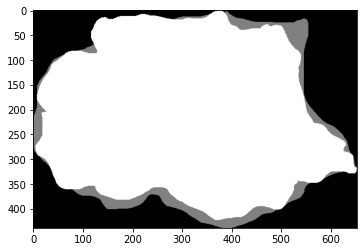

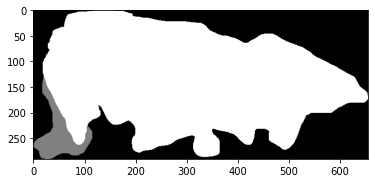

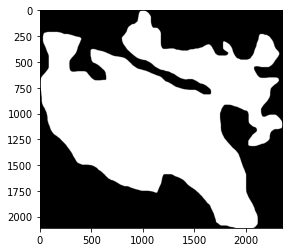

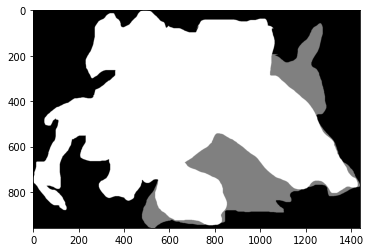

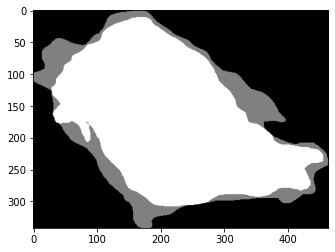

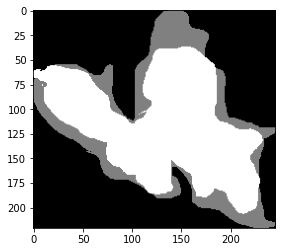

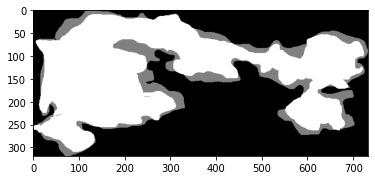

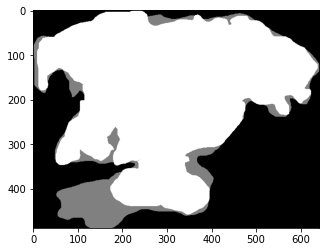

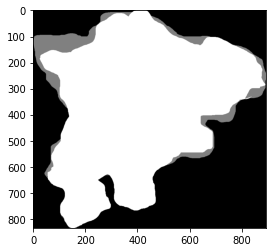

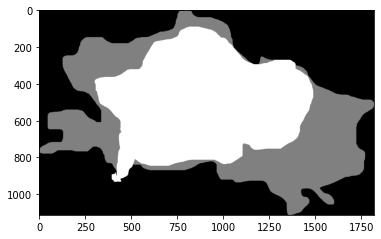

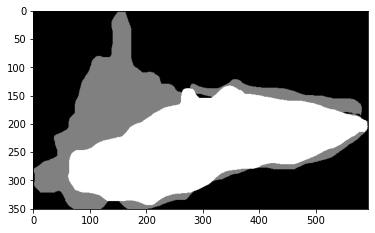

In [12]:
cropped_mask = {}
for name in masks.keys():
    binary_mask = masks[name][:, :, -1]
    rows, cols = np.nonzero(binary_mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    size = np.max([size_1, size_2])
    bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
    cropped_mask[name] = masks[name][min_row:max_row+1, min_col:max_col+1]
    plt.imshow(cropped_mask[name][:,:,-1], cmap='gray')
    plt.show()

max size: 2348
sizes: [653, 655, 2348, 1440, 464, 246, 733, 642, 892, 1820, 593]
max size index: 2
name of max size: Beniarda


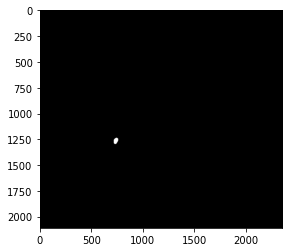

centroid: 1264 733


In [13]:
def get_bounding_square(mask):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    size = np.max([size_1, size_2])
    return size

sizes = [get_bounding_square(cropped_mask[name][:,:,-1]) for name in cropped_mask.keys()]
size = np.max(sizes)
if size%2 == 1:
    size += 1
print('max size:', size)
print('sizes:', sizes)
print('max size index:', np.argmax(np.array(sizes)))

name_max_size = list(cropped_mask.keys())[np.argmax(np.array(sizes))]
print('name of max size:', name_max_size)

current_mask = cropped_mask[name_max_size][:,:,0]
plt.imshow(current_mask, cmap='gray')
plt.show()

rows, cols = np.nonzero(current_mask)
n = len(rows)
centroid_x = np.round(np.sum(rows) / n).astype(int)
centroid_y = np.round(np.sum(cols) / n).astype(int)
print('centroid:', centroid_x, centroid_y)

In [14]:
    """
    masks_cropped = {}
def pad_mask(mask, size):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    row_padding = (size - size_1) // 2
    col_padding = (size - size_2) // 2
    padded_mask = np.zeros((size, size))
    padded_mask[row_padding:row_padding + size_1, col_padding:col_padding + size_2] = mask[min_row:max_row + 1, min_col:max_col + 1]
    return padded_mask

for name in masks.keys():
    z = masks[name].shape[-1]
    aux = np.zeros(shape=(size, size, z))
    for i in range(masks[name].shape[-1]):
        binary_mask = masks[name][:, :, i]
        padded_mask = pad_mask(binary_mask, size)
        aux[:,:, i] = padded_mask.copy()
    masks_cropped[name] = aux.copy()
    #binary_mask = masks[name][:, :, -1]
    #padded_mask = pad_mask(binary_mask, size)
    #plt.imshow(padded_mask, cmap='gray')
    #aux[name] = padded_mask.copy()
    """

"\nmasks_cropped = {}\ndef pad_mask(mask, size):\nrows, cols = np.nonzero(mask)\nmin_row, max_row = np.min(rows), np.max(rows)\nmin_col, max_col = np.min(cols), np.max(cols)\nsize_1, size_2 = max_row - min_row + 1, max_col - min_col + 1\nrow_padding = (size - size_1) // 2\ncol_padding = (size - size_2) // 2\npadded_mask = np.zeros((size, size))\npadded_mask[row_padding:row_padding + size_1, col_padding:col_padding + size_2] = mask[min_row:max_row + 1, min_col:max_col + 1]\nreturn padded_mask\n\nfor name in masks.keys():\nz = masks[name].shape[-1]\naux = np.zeros(shape=(size, size, z))\nfor i in range(masks[name].shape[-1]):\n    binary_mask = masks[name][:, :, i]\n    padded_mask = pad_mask(binary_mask, size)\n    aux[:,:, i] = padded_mask.copy()\nmasks_cropped[name] = aux.copy()\n#binary_mask = masks[name][:, :, -1]\n#padded_mask = pad_mask(binary_mask, size)\n#plt.imshow(padded_mask, cmap='gray')\n#aux[name] = padded_mask.copy()\n"

In [15]:
init = size - np.array(sizes)
init

array([1695, 1693,    0,  908, 1884, 2102, 1615, 1706, 1456,  528, 1755],
      dtype=int64)

In [16]:
for name in cropped_mask.keys():
    print(cropped_mask[name].shape)

(439, 653, 9)
(291, 655, 9)
(2108, 2348, 3)
(958, 1440, 10)
(342, 464, 10)
(221, 246, 7)
(319, 733, 12)
(488, 642, 18)
(834, 892, 11)
(1112, 1820, 5)
(351, 593, 4)


In [17]:
masks_cropped = {}

for i, name in enumerate(cropped_mask.keys()):
    # Crea un nuevo array tridimensional para contener todas las máscaras
    new_array = np.zeros((size, size, cropped_mask[name].shape[-1]), dtype=cropped_mask[name].dtype)

    a = init[i]//2
    max_x = cropped_mask[name].shape[0]
    max_y = cropped_mask[name].shape[1]
    new_array[a:(a + max_x) , a: (a + max_y) , :] = cropped_mask[name]
    # Almacena la máscara trasladada en el nuevo diccionario
    masks_cropped[name] = new_array.copy()


In [18]:
    """
    masks_cropped = {}

# Encuentra la máscara más grande
sizes = [get_bounding_square(masks[name][:,:,-1]) for name in masks.keys()]
size = np.max(sizes)
if size % 2 == 1:
    size += 1
print('max size:', size)
print('sizes:', sizes)
print('max size index:', np.argmax(np.array(sizes)))

# Encuentra la máscara correspondiente a la máscara más grande y sus coordenadas de centroide
name_max_size = list(masks.keys())[np.argmax(np.array(sizes))]
print('name of max size:', name_max_size)
current_mask = masks[name_max_size][:,:,0]
rows, cols = np.nonzero(current_mask)
n = len(rows)
centroid_x = np.round(np.sum(rows) / n).astype(int)
centroid_y = np.round(np.sum(cols) / n).astype(int)
print('centroid:', centroid_x, centroid_y)



for name in masks.keys():
    # Crea un nuevo array tridimensional para contener todas las máscaras
    new_array = np.zeros((size, size, masks[name].shape[-1]), dtype=masks[name].dtype)
    # Encuentra la cantidad de traslación necesaria para centrar el centroide en el nuevo array
    binary_mask = masks[name][:, :, 0]
    rows, cols = np.nonzero(binary_mask)
    n = len(rows)
    current_centroid_x = np.round(np.sum(rows) / n).astype(int)
    current_centroid_y = np.round(np.sum(cols) / n).astype(int)
    dx = centroid_x - current_centroid_x
    dy = centroid_y - current_centroid_y

    # Traslada todo el array y copia las componentes temporales en el nuevo array
    cy, cx = binary_mask.shape
    y_start = max(0, dy)
    y_end = min(cy + dy, size)
    x_start = max(0, dx)
    x_end = min(cx + dx, size)
    new_array[x_start:x_end, y_start:y_end, :] = masks[name][(x_start-dx):(x_end-dx),(y_start-dy):(y_end-dy), :]

    # Almacena la máscara trasladada en el nuevo diccionario
    masks_cropped[name] = new_array.copy()
    """

"\nmasks_cropped = {}\n\n# Encuentra la máscara más grande\nsizes = [get_bounding_square(masks[name][:,:,-1]) for name in masks.keys()]\nsize = np.max(sizes)\nif size % 2 == 1:\nsize += 1\nprint('max size:', size)\nprint('sizes:', sizes)\nprint('max size index:', np.argmax(np.array(sizes)))\n\n# Encuentra la máscara correspondiente a la máscara más grande y sus coordenadas de centroide\nname_max_size = list(masks.keys())[np.argmax(np.array(sizes))]\nprint('name of max size:', name_max_size)\ncurrent_mask = masks[name_max_size][:,:,0]\nrows, cols = np.nonzero(current_mask)\nn = len(rows)\ncentroid_x = np.round(np.sum(rows) / n).astype(int)\ncentroid_y = np.round(np.sum(cols) / n).astype(int)\nprint('centroid:', centroid_x, centroid_y)\n\n\n\nfor name in masks.keys():\n# Crea un nuevo array tridimensional para contener todas las máscaras\nnew_array = np.zeros((size, size, masks[name].shape[-1]), dtype=masks[name].dtype)\n# Encuentra la cantidad de traslación necesaria para centrar el cen

Artana
(2348, 2348, 9) (2349, 2349, 9)


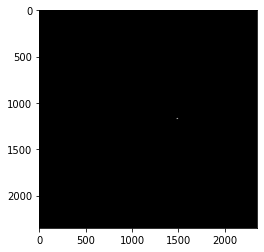

Beneixama
(2348, 2348, 9) (2349, 2349, 9)


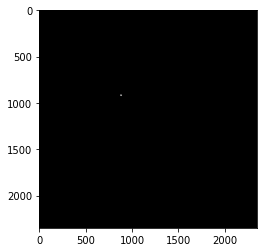

Beniarda
(2348, 2348, 3) (2349, 2349, 3)


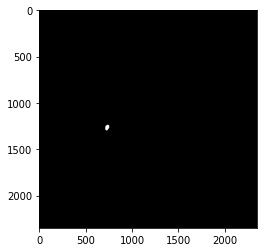

Bolulla
(2348, 2348, 10) (2349, 2349, 10)


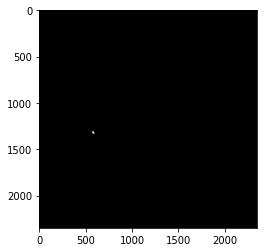

Carcaixent
(2348, 2348, 10) (2349, 2349, 10)


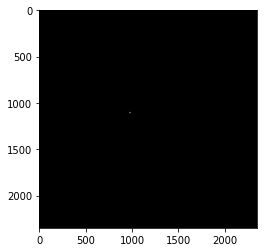

Chella
(2348, 2348, 7) (2349, 2349, 7)


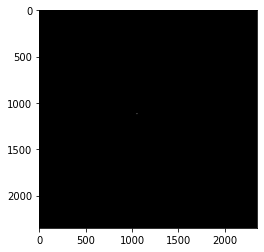

Gatova
(2348, 2348, 12) (2349, 2349, 12)


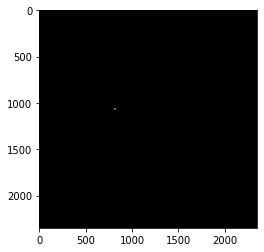

Llutxent
(2348, 2348, 18) (2349, 2349, 18)


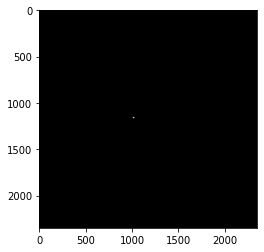

Montan
(2348, 2348, 11) (2349, 2349, 11)


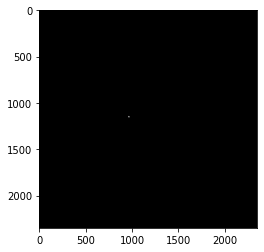

ValldEbo
(2348, 2348, 5) (2349, 2349, 5)


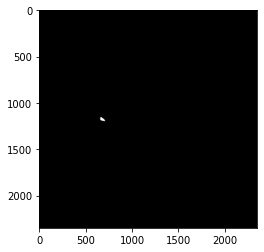

VallGallinera
(2348, 2348, 4) (2349, 2349, 4)


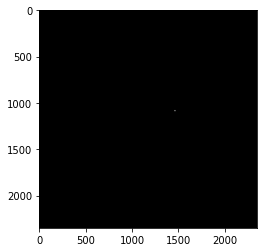

In [19]:
for name in masks_cropped.keys():
    print(name)
    shape = masks_cropped[name].shape[0] + 1, masks_cropped[name].shape[1] + 1, masks_cropped[name].shape[2]
    print(masks_cropped[name].shape, shape)
    #print(np.where(masks_cropped[name][:,:,0] == 2))
    test = np.zeros(shape=shape)
    test[1:, 1:, :] = masks_cropped[name][:,:,:]
    try:
        plt.imshow(test[:, :, 0], cmap='gray')
        plt.show()
    except:
        pass

In [20]:
masks_crop_resize = {}
resize = 256
for name in masks_cropped.keys():
    z = masks_cropped[name].shape[-1]
    aux = np.zeros(shape=(resize, resize, z))
    for i in range(masks_cropped[name].shape[-1]):
        binary_mask = masks_cropped[name][:, :, i]
        aux[:,:, i] = cv2.resize(binary_mask, (resize, resize), interpolation=cv2.INTER_NEAREST)
    masks_crop_resize[name] = aux.copy()

In [21]:
masks_crop_resize['Beniarda'] = masks_crop_resize['Beniarda'][:, :, :-1].copy()

Artana (256, 256, 9)
(array([], dtype=int64), array([], dtype=int64))
(array([117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121,
       121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122,
       122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123,
       123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124,
       124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125,
       125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 127, 127, 127, 127, 127, 128, 128], dtype=int64), array([151, 152, 153, 150, 151, 152, 153, 154, 155, 156, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 148, 149, 150, 151, 152, 153, 154, 155, 156,
   

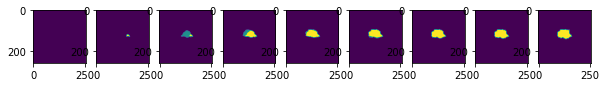

Beneixama (256, 256, 9)
(array([100, 100], dtype=int64), array([96, 97], dtype=int64))
(array([ 98,  98,  98,  99,  99,  99,  99,  99, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101,
       101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103,
       103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104,
       104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106,
       106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107,
       107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107,
       108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
       108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 111, 111, 111, 111, 111, 1

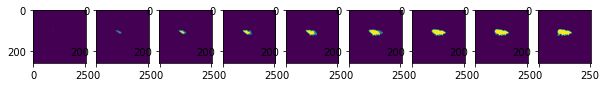

Beniarda (256, 256, 2)
(array([135, 135, 136, 136, 136, 136, 137, 137, 137, 137, 137, 138, 138,
       138, 138, 138, 139, 139, 139, 139, 140, 140, 140, 140, 141, 141],
      dtype=int64), array([80, 81, 79, 80, 81, 82, 78, 79, 80, 81, 82, 78, 79, 80, 81, 82, 78,
       79, 80, 81, 78, 79, 80, 81, 79, 80], dtype=int64))
(array([  0,   0,   1, ..., 229, 229, 229], dtype=int64), array([108, 109, 106, ..., 224, 225, 226], dtype=int64))


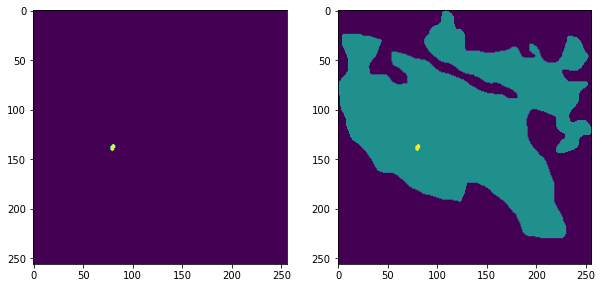

Bolulla (256, 256, 10)
(array([143, 143, 144, 144, 145, 145], dtype=int64), array([63, 64, 63, 64, 64, 65], dtype=int64))
(array([123, 124, 124, 125, 125, 126, 126, 127, 127, 128, 128, 128, 128,
       129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 131, 131, 131,
       131, 131, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133,
       134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 136, 136, 136,
       136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137,
       138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139,
       139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141,
       141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 143, 143, 143,
       143, 144], dtype=int64), array([52, 52, 53, 52, 53, 52, 53, 52, 53, 51, 52, 53, 54, 50, 51, 52, 53,
       54, 50, 51, 52, 53, 54, 50, 51, 52, 53, 54, 50, 51, 52, 53, 54, 55,
       51, 52, 53, 54, 55, 52, 53, 54, 55, 56, 53, 54, 55, 56, 57, 53, 54,
       55, 56, 57, 58, 59, 60, 54, 55, 56, 5

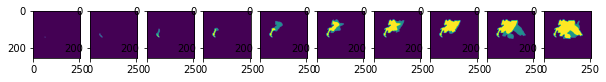

Carcaixent (256, 256, 10)
(array([120, 121], dtype=int64), array([107, 107], dtype=int64))
(array([119, 120, 120, 121], dtype=int64), array([109, 108, 109, 108], dtype=int64))
(array([118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121,
       121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122],
      dtype=int64), array([117, 118, 119, 120, 121, 122, 123, 124, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 109, 110, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 108, 119, 120, 121],
      dtype=int64))
(array([118, 118, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121,
       121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122

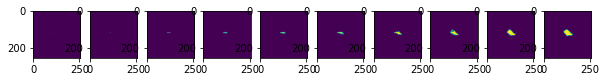

Chella (256, 256, 7)
(array([122], dtype=int64), array([115], dtype=int64))
(array([122, 122, 122, 123, 123], dtype=int64), array([116, 117, 118, 117, 118], dtype=int64))
(array([121, 121, 122, 122, 123, 123, 123, 124, 124, 124, 124, 124, 124,
       125, 125, 125, 125, 125, 125, 126, 126], dtype=int64), array([117, 118, 119, 120, 119, 120, 121, 117, 118, 119, 120, 121, 122,
       118, 119, 120, 121, 122, 123, 122, 123], dtype=int64))
(array([124, 125, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127,
       127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130,
       130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131,
       131, 132, 132, 132, 132, 132, 133, 133], dtype=int64), array([116, 117, 117, 118, 119, 120, 121, 118, 119, 120, 121, 122, 123,
       124, 125, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 126

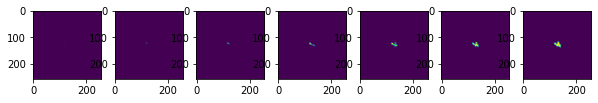

Gatova (256, 256, 12)
(array([116, 116], dtype=int64), array([88, 89], dtype=int64))
(array([113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114,
       114, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116],
      dtype=int64), array([ 95,  96,  97,  98,  99, 100,  93,  94,  95,  96,  97,  98,  99,
       100,  91,  92,  93,  94,  95,  96,  90,  91,  92,  93,  94],
      dtype=int64))
(array([109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114,
       114, 114, 

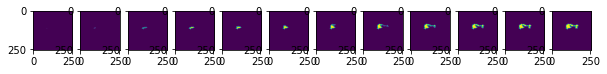

Llutxent (256, 256, 18)
(array([126, 126, 127], dtype=int64), array([110, 111, 111], dtype=int64))
(array([124, 124, 124, 125, 125, 125, 125, 126, 126, 126, 126, 127, 127,
       127, 127, 127, 128, 128, 128, 128, 129], dtype=int64), array([107, 108, 109, 107, 108, 109, 110, 107, 108, 109, 112, 107, 108,
       109, 110, 112, 108, 109, 110, 111, 109], dtype=int64))
(array([122, 122, 122, 122, 123, 123, 123, 123, 123, 124, 124, 124, 124,
       124, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 127, 127,
       129, 129], dtype=int64), array([102, 103, 104, 105, 102, 103, 104, 105, 106, 102, 103, 104, 105,
       106, 102, 103, 104, 105, 106, 102, 103, 104, 105, 106, 105, 106,
       108, 110], dtype=int64))
(array([119, 119, 119, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121,
       121, 121, 121, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123,
       123, 124, 124, 124, 125, 125, 126, 128, 128], dtype=int64), array([104, 105, 106, 103, 104, 105, 106, 107, 102, 103, 104, 105, 

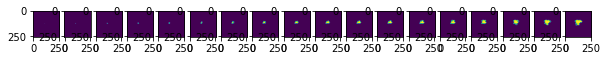

Montan (256, 256, 11)
(array([125, 125], dtype=int64), array([105, 106], dtype=int64))
(array([124, 124, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126],
      dtype=int64), array([103, 104, 102, 103, 104, 107, 102, 103, 104, 105, 106, 107],
      dtype=int64))
(array([112, 113, 114, 114, 114, 114, 115, 115, 115, 115, 115, 116, 116,
       116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117,
       118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121,
       121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122,
       122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
       123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124,
       124, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127

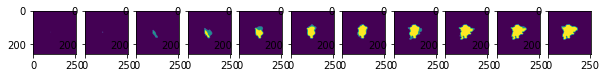

ValldEbo (256, 256, 5)
(array([126, 126, 127, 127, 127, 128, 128, 128, 128, 128, 129, 129, 129,
       129, 129, 130, 130, 130], dtype=int64), array([72, 73, 72, 73, 74, 72, 73, 74, 75, 76, 73, 74, 75, 76, 77, 75, 76,
       77], dtype=int64))
(array([ 76,  76,  76,  76,  76,  77,  77,  77,  77,  77,  77,  77,  78,
        78,  78,  78,  78,  78,  78,  78,  78,  78,  79,  79,  79,  79,
        79,  79,  79,  79,  79,  79,  79,  79,  80,  80,  80,  80,  80,
        80,  80,  80,  80,  80,  80,  80,  80,  80,  81,  81,  81,  81,
        81,  81,  81,  81,  81,  81,  81,  81,  81,  81,  81,  81,  82,
        82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
        82,  82,  82,  82,  82,  83,  83,  83,  83,  83,  83,  83,  83,
        83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,
        84,  84,  84,  84,  84,  84,  84,  84,  84,  84,  84,  84,  84,
        84,  84,  84,  84,  84,  84,  84,  84,  84,  85,  85,  85,  85,
        85,  85,  85,  85,  85,  85

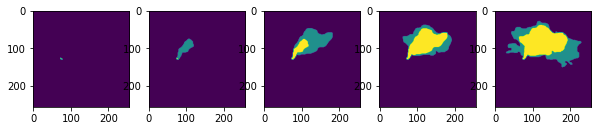

VallGallinera (256, 256, 4)
(array([118], dtype=int64), array([160], dtype=int64))
(array([117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 121, 121], dtype=int64), array([154, 155, 156, 157, 158, 159, 160, 147, 148, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 153, 154], dtype=int64))
(array([111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114,
       114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114,
       114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114,
       114, 114, 115, 115, 115, 115, 115, 115, 11

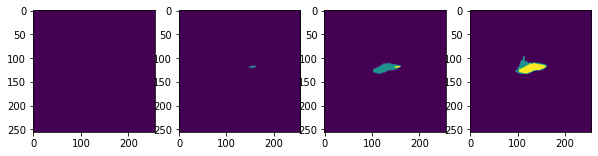

In [22]:
for name in masks_crop_resize.keys():
    print(name, masks_crop_resize[name].shape)
    fig, ax = plt.subplots(1, masks_crop_resize[name].shape[-1], figsize=(10, 5))
    for i in range(masks_crop_resize[name].shape[-1]):
        binary_mask = masks_crop_resize[name][:, :, i]
        ax[i].imshow(binary_mask)
        print(np.where(binary_mask == 1))
    plt.show()

In [23]:
for name in masks_crop_resize.keys():
    if np.sum(masks_crop_resize[name][:,:,0]) == 0:
        print(name)

Artana


In [24]:
for name in masks_crop_resize.keys():
    print(name, np.where(masks_crop_resize[name][:,:,0] == 1))

Artana (array([], dtype=int64), array([], dtype=int64))
Beneixama (array([100, 100], dtype=int64), array([96, 97], dtype=int64))
Beniarda (array([135, 135, 136, 136, 136, 136, 137, 137, 137, 137, 137, 138, 138,
       138, 138, 138, 139, 139, 139, 139, 140, 140, 140, 140, 141, 141],
      dtype=int64), array([80, 81, 79, 80, 81, 82, 78, 79, 80, 81, 82, 78, 79, 80, 81, 82, 78,
       79, 80, 81, 78, 79, 80, 81, 79, 80], dtype=int64))
Bolulla (array([143, 143, 144, 144, 145, 145], dtype=int64), array([63, 64, 63, 64, 64, 65], dtype=int64))
Carcaixent (array([120, 121], dtype=int64), array([107, 107], dtype=int64))
Chella (array([122], dtype=int64), array([115], dtype=int64))
Gatova (array([116, 116], dtype=int64), array([88, 89], dtype=int64))
Llutxent (array([126, 126, 127], dtype=int64), array([110, 111, 111], dtype=int64))
Montan (array([125, 125], dtype=int64), array([105, 106], dtype=int64))
ValldEbo (array([126, 126, 127, 127, 127, 128, 128, 128, 128, 128, 129, 129, 129,
       129

Artana
(256, 256, 9) (257, 257, 9)


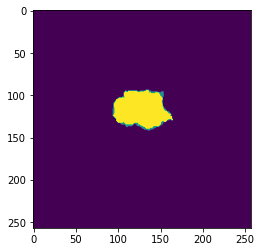

Beneixama
(256, 256, 9) (257, 257, 9)


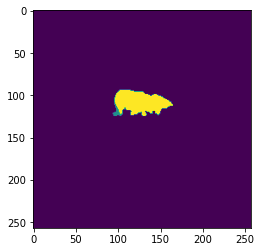

Beniarda
(256, 256, 2) (257, 257, 2)


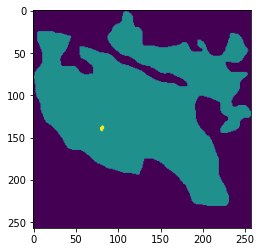

Bolulla
(256, 256, 10) (257, 257, 10)


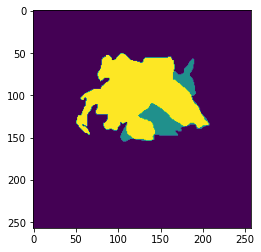

Carcaixent
(256, 256, 10) (257, 257, 10)


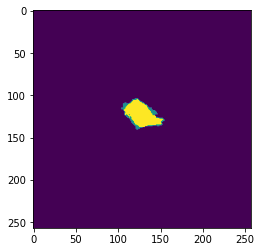

Chella
(256, 256, 7) (257, 257, 7)


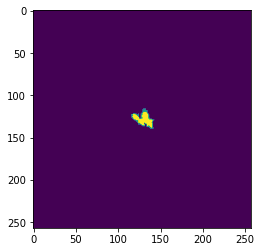

Gatova
(256, 256, 12) (257, 257, 12)


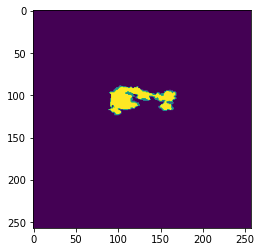

Llutxent
(256, 256, 18) (257, 257, 18)


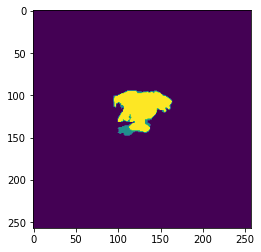

Montan
(256, 256, 11) (257, 257, 11)


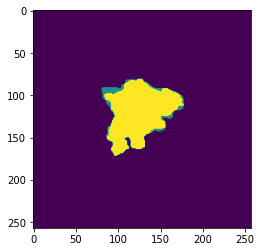

ValldEbo
(256, 256, 5) (257, 257, 5)


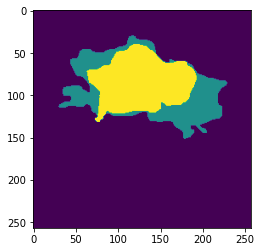

VallGallinera
(256, 256, 4) (257, 257, 4)


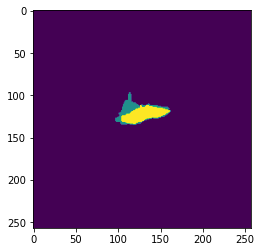

In [25]:
for name in masks_crop_resize.keys():
    print(name)
    shape = masks_crop_resize[name].shape[0] + 1, masks_crop_resize[name].shape[1] + 1, masks_crop_resize[name].shape[2]
    print(masks_crop_resize[name].shape, shape)
    test = np.zeros(shape=shape)
    test[1:, 1:, :] = masks_crop_resize[name][:,:,:]
    masks_crop_resize[name] = test.copy()
    plt.imshow(test[:, :, -1])
    plt.show()

In [26]:
with open('grid_data_dict/masks_scaled.pkl', 'wb') as f:
    pickle.dump(masks_crop_resize, f)

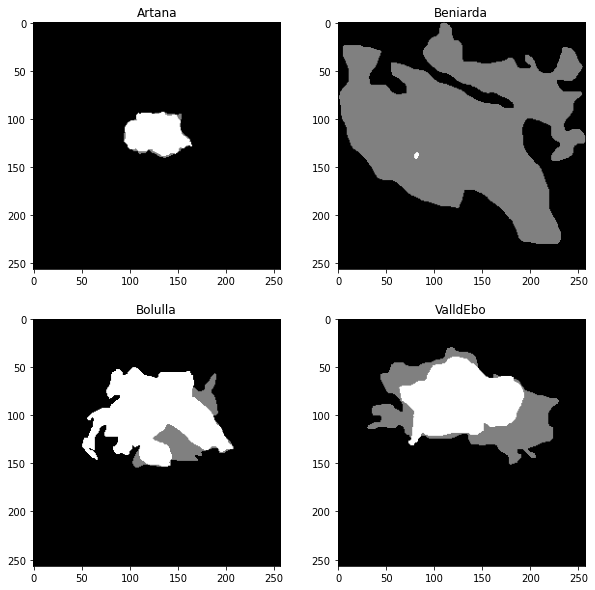

In [27]:
# Lista con los nombres que deseas visualizar
names_to_show = ["Artana", "Beniarda", "Bolulla", "ValldEbo"]

# Crear una figura con subplots divididos en 4 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Recorrer los subplots y agregar la imagen correspondiente
for i, ax in enumerate(axs.ravel()):
    if i < len(names_to_show):
        name = names_to_show[i]
        ax.imshow(masks_crop_resize[name][:, :, -1], cmap='gray')
        ax.set_title(name)

# Mostrar la figura
plt.savefig('Figures/masks_crop_resize.png')
plt.show()


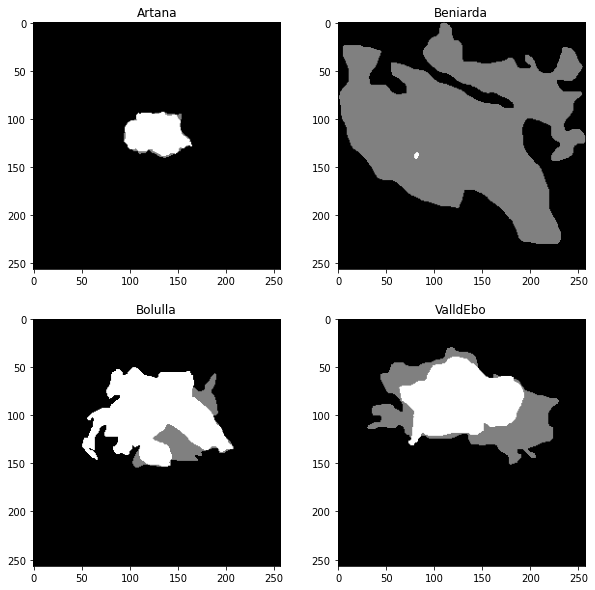

In [28]:
fig

In [29]:
with open('grid_data_dict/masks_scaled.pkl', 'wb') as f:
    pickle.dump(masks_crop_resize, f)

# 4. Guardamos todo en un dict

In [30]:
dict_data_final = {}
path = 'C:\\Users\\joanb\\Desktop\\data_incendios\\FINAL_DATA\\dataframes\\'
path_nps = 'C:\\Users\\joanb\\Desktop\\data_incendios\\FINAL_DATA\\masks\\'

df_train = pd.read_csv('train_masks.csv')


for file in os.listdir(path):
    name = file.split('_')[1]
    df = pd.read_csv(path + file, sep=';', index_col=0)
    fecha_train = pd.to_datetime(df_train[name][~df_train[name].isna()].values, format='%d/%m/%Y %H:%M:%S')
    df['Train'] = df.index.astype(fecha_train.dtype).isin(fecha_train)
    binary_mask = masks_crop_resize[name]
    np.save(path_nps + 'grid_' + name + '.npy', binary_mask)
    # if Theta is less than zero, then this value has to be the same as the previous one
    df['Theta'][df['Theta']<0] = np.nan
    df['Theta'] = df['Theta'].fillna(method='ffill')   
    dict_data_final[name] = (df, binary_mask)

with open('grid_data_dict/dict_data_final.pkl', 'wb') as f:
    pickle.dump(dict_data_final, f)

C:\Users\joanb\AppData\Local\Temp\ipykernel_8312\901122388.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Theta'][df['Theta']<0] = np.nan
C:\Users\joanb\AppData\Local\Temp\ipykernel_8312\901122388.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Theta'][df['Theta']<0] = np.nan
C:\Users\joanb\AppData\Local\Temp\ipykernel_8312\901122388.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Theta'][df['Theta']<0] = np

Artana
                     Temperatura  Humedad       Rho     Theta  Train
Fecha                                                               
2016-07-25 15:00:00        28.81    44.63  0.908365  2.652900   True
2016-07-25 15:30:00        27.61    49.51  0.894910  2.474877  False
2016-07-25 16:00:00        27.30    53.80  0.814218  2.537709   True
2016-07-25 16:30:00        27.42    52.78  0.794672  2.448697  False
2016-07-25 17:00:00        27.51    50.66  0.758823  2.431244  False
...                          ...      ...       ...       ...    ...
2016-07-27 10:00:00        27.81    62.03  0.656967  2.405064  False
2016-07-27 10:30:00        27.01    67.93  0.648663  2.012365  False
2016-07-27 11:00:00        27.86    65.52  0.790158  2.183407  False
2016-07-27 11:30:00        27.21    67.24  0.783200  2.638938  False
2016-07-27 12:00:00        27.10    68.17  0.827459  2.565634   True

[91 rows x 5 columns]


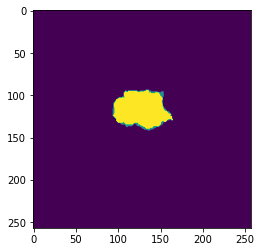

Beneixama
                     Temperatura    Humedad       Rho     Theta  Train
Fecha                                                                 
2019-07-15 14:00:00    34.000000  27.000000  0.992820  4.712389   True
2019-07-15 14:30:00    33.804940  26.988157  0.994792  5.515899   True
2019-07-15 15:00:00    34.549110  26.998247  0.998886  5.080164   True
2019-07-15 15:30:00    34.798327  25.995983  0.947882  5.490297   True
2019-07-15 16:00:00    35.567543  22.469045  0.958420  4.996098   True
2019-07-15 16:30:00    35.440671  19.694720  0.999076  4.689727  False
2019-07-15 17:00:00    35.486595  18.318667  0.982733  5.112138  False
2019-07-15 17:30:00    35.348831  17.417553  0.963659  5.203085   True
2019-07-15 18:00:00    35.578373  15.901377  0.983772  4.683797  False
2019-07-15 18:30:00    34.753903  27.698387  0.948130  6.984050   True
2019-07-15 19:00:00    33.033794  37.207983  0.972815  0.375628  False
2019-07-15 19:30:00    32.179913  39.825633  0.995339  0.650459   T

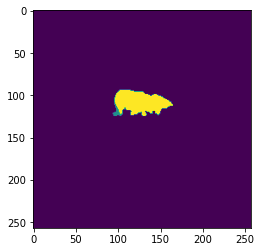

Beniarda
                     Temperatura  Humedad       Rho     Theta  Train
Fecha                                                               
2020-08-28 21:00:00         26.0     59.0  0.647898  3.612832   True
2020-08-28 21:30:00         26.2     55.0  0.293862  3.508112  False
2020-08-28 22:00:00         25.8     53.0  0.501369  3.612832  False
2020-08-28 22:30:00         26.2     52.0  0.000000  3.455752  False
2020-08-28 23:00:00         25.8     52.0  0.293862  4.276057  False
2020-08-28 23:30:00         24.7     56.0  0.501369  3.612832  False
2020-08-29 00:00:00         25.3     51.0  0.000000  4.276057  False
2020-08-29 00:30:00         25.2     47.0  0.293862  4.310963  False
2020-08-29 01:00:00         25.1     47.0  0.293862  2.548181  False
2020-08-29 01:30:00         24.9     47.0  0.751367  4.450590  False
2020-08-29 02:00:00         24.7     46.0  0.293862  4.607669  False
2020-08-29 02:30:00         24.3     44.0  0.501369  3.333579  False
2020-08-29 03:00:00      

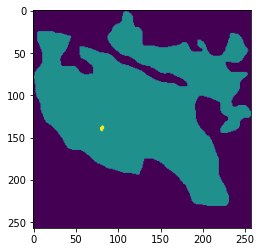

Bolulla
                     Temperatura    Humedad       Rho     Theta  Train
Fecha                                                                 
2016-09-04 18:30:00    25.530000  17.420000  0.216169  0.606676   True
2016-09-04 19:00:00    25.680919  16.040388  0.250326  0.981638  False
2016-09-04 19:30:00    25.489002  16.080438  0.267567  0.667278  False
2016-09-04 20:00:00    25.490393  15.638014  0.244565  0.895403  False
2016-09-04 20:30:00    25.340995  15.298976  0.195963  0.895403   True
...                          ...        ...       ...       ...    ...
2016-09-06 17:00:00    30.787159  35.425314  0.391516  4.043952  False
2016-09-06 17:30:00    29.838667  38.521407  0.344837  3.876028  False
2016-09-06 18:00:00    28.546008  42.996024  0.323834  3.837110  False
2016-09-06 18:30:00    27.223339  47.731207  0.189734  4.154366  False
2016-09-06 19:00:00    25.900000  52.440000  0.057025  4.401720   True

[98 rows x 5 columns]


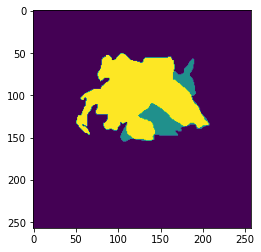

Carcaixent
                     Temperatura    Humedad       Rho     Theta  Train
Fecha                                                                 
2016-06-16 17:00:00    23.753846  27.000000  0.577330  4.398230   True
2016-06-16 17:30:00    23.753846  28.488864  0.482162  4.360725  False
2016-06-16 18:00:00    23.753846  29.000000  0.638589  4.415683   True
2016-06-16 18:30:00    23.753846  29.261136  0.766756  4.496821  False
2016-06-16 19:00:00    23.753846  30.000000  0.774055  4.537856   True
...                          ...        ...       ...       ...    ...
2016-06-18 07:00:00    19.900000  81.000000  0.075302  0.017453  False
2016-06-18 07:30:00    20.693416  79.202636  0.203482  0.017453  False
2016-06-18 08:00:00    21.400000  68.000000  0.374826  0.785398  False
2016-06-18 08:30:00    22.231584  56.797364  0.528148  1.588571  False
2016-06-18 09:00:00    23.400000  55.000000  0.638589  1.169371   True

[81 rows x 5 columns]


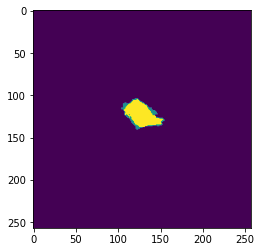

Chella
                     Temperatura  Humedad       Rho     Theta  Train
Fecha                                                               
2016-06-15 20:00:00        26.10    23.26  0.791523  4.977679   True
2016-06-15 20:30:00        25.63    24.15  0.801694  4.972443   True
2016-06-15 21:00:00        25.03    26.54  0.800829  4.974188  False
2016-06-15 21:30:00        24.36    29.01  0.804690  4.965462  False
2016-06-15 22:00:00        24.05    29.21  0.755124  4.918338  False
...                          ...      ...       ...       ...    ...
2016-06-17 07:00:00        20.10    46.39  0.615898  3.902556  False
2016-06-17 07:30:00        21.41    42.96  0.608307  3.900811  False
2016-06-17 08:00:00        22.96    37.93  0.544894  4.579744  False
2016-06-17 08:30:00        23.61    36.24  0.533876  3.420845  False
2016-06-17 09:00:00        24.22    34.58  0.447709  2.713987   True

[75 rows x 5 columns]


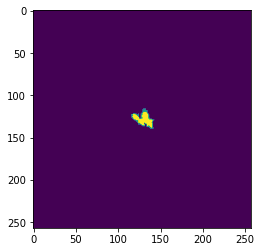

Gatova
                     Temperatura  Humedad       Rho     Theta  Train
Fecha                                                               
2017-06-28 19:30:00        26.83    30.08  0.635431  4.639085   True
2017-06-28 20:00:00        26.51    30.40  0.756716  4.817109  False
2017-06-28 20:30:00        26.47    30.47  0.671567  4.769985  False
2017-06-28 21:00:00        25.94    32.13  0.396205  5.188864   True
2017-06-28 21:30:00        24.48    37.41  0.234696  5.141740  False
...                          ...      ...       ...       ...    ...
2017-06-30 13:00:00        25.31    30.87  0.895594  1.809906  False
2017-06-30 13:30:00        24.78    31.96  0.847905  2.200860  False
2017-06-30 14:00:00        25.04    34.47  0.858745  2.352704  False
2017-06-30 14:30:00        24.37    37.63  0.856578  2.371902  False
2017-06-30 15:00:00        22.94    41.18  0.870513  2.076942   True

[88 rows x 5 columns]


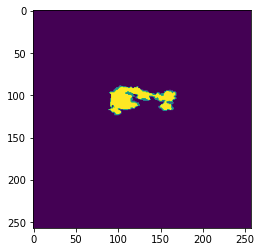

Llutxent
                     Temperatura    Humedad       Rho     Theta  Train
Fecha                                                                 
2018-08-06 14:30:00    37.200000  35.000000  0.993332  2.356194   True
2018-08-06 15:00:00    36.815838  32.365296  0.970567  3.372475  False
2018-08-06 15:30:00    36.896037  31.015054  0.913182  4.005388  False
2018-08-06 16:00:00    37.129319  30.651821  0.815513  4.349611  False
2018-08-06 16:30:00    37.204404  30.978141  0.695555  4.499821   True
...                          ...        ...       ...       ...    ...
2018-08-08 18:00:00    27.074712  72.088916  0.629636  4.125879  False
2018-08-08 18:30:00    26.972981  72.564731  0.461690  1.952488  False
2018-08-08 19:00:00    27.408154  72.003077  0.466723  0.564880  False
2018-08-08 19:30:00    27.557929  74.212114  0.553775  1.244026  False
2018-08-08 20:00:00    26.600000  83.000000  0.609158  5.270894   True

[108 rows x 5 columns]


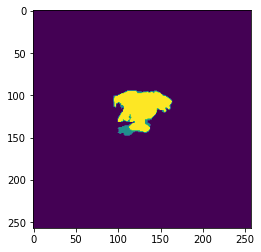

Montan
                     Temperatura    Humedad       Rho     Theta  Train
Fecha                                                                 
2015-07-07 17:00:00    24.000000  80.000000  0.209321  3.822271   True
2015-07-07 17:30:00    24.855050  76.179153  0.230186  2.830666   True
2015-07-07 18:00:00    25.500000  68.000000  0.209321  3.298672  False
2015-07-07 18:30:00    25.794950  59.320847  0.171839  4.342637  False
2015-07-07 19:00:00    25.600000  54.000000  0.144933  5.078908  False
...                          ...        ...       ...       ...    ...
2015-07-10 08:00:00    23.700000  69.000000  0.209321  1.099557  False
2015-07-10 08:30:00    24.748856  64.461449  0.306217  1.282731  False
2015-07-10 09:00:00    25.700000  62.000000  0.421903  1.361357  False
2015-07-10 09:30:00    26.426144  60.538551  0.554571  1.535975  False
2015-07-10 10:00:00    26.800000  59.000000  0.690969  2.007129   True

[131 rows x 5 columns]


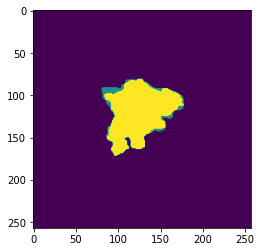

ValldEbo
                     Temperatura    Humedad       Rho     Theta  Train
Fecha                                                                 
2015-05-14 11:00:00    38.050000   9.150000  0.659198  3.267256   True
2015-05-14 11:30:00    38.270000   9.440000  0.717330  3.080506  False
2015-05-14 12:00:00    38.420000   8.590000  0.736332  4.152138  False
2015-05-14 12:30:00    38.390000   8.740000  0.680722  2.644174  False
2015-05-14 13:00:00    38.350000   8.880000  0.833721  2.293363  False
2015-05-14 13:30:00    38.260000   9.660000  0.825193  2.342232  False
2015-05-14 14:00:00    38.020000  11.280000  0.843203  2.357940   True
2015-05-14 14:30:00    37.810000  11.330000  0.813408  1.968731  False
2015-05-14 15:00:00    36.950000  11.970000  0.837652  2.036799  False
2015-05-14 15:30:00    35.780000  13.110000  0.844899  2.183407  False
2015-05-14 16:00:00    35.880000  13.180000  0.785545  2.096140  False
2015-05-14 16:30:00    35.730000  12.750000  0.786940  1.982694   Tr

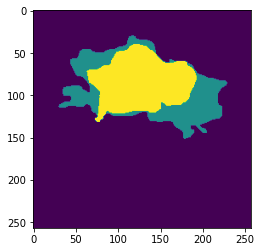

VallGallinera
                     Temperatura  Humedad       Rho     Theta  Train
Fecha                                                               
2020-08-08 16:30:00         38.3     20.0  0.745901  1.797689   True
2020-08-08 17:00:00         38.6     17.0  0.781781  1.727876  False
2020-08-08 17:30:00         38.6     17.0  0.828208  1.815142   True
2020-08-08 18:00:00         38.5     17.0  0.812595  1.832596  False
2020-08-08 18:30:00         38.6     17.0  0.704122  2.076942  False
...                          ...      ...       ...       ...    ...
2020-08-10 18:00:00         35.1     28.0  0.849222  1.797689  False
2020-08-10 18:30:00         34.6     27.0  0.767070  2.111848  False
2020-08-10 19:00:00         33.4     28.0  0.756716  1.692969  False
2020-08-10 19:30:00         32.6     29.0  0.761949  1.658063  False
2020-08-10 20:00:00         31.8     30.0  0.751367  1.797689   True

[104 rows x 5 columns]


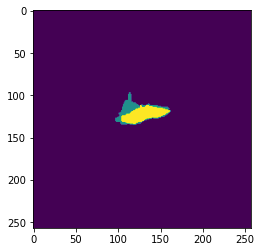

In [31]:
for name in dict_data_final.keys():
    print(name)
    print(dict_data_final[name][0])
    plt.imshow(dict_data_final[name][1][:, :, -1])
    plt.show()

In [32]:
df, grid = dict_data_final['Bolulla']